<a href="https://colab.research.google.com/github/rts1988/Duolingo_spaced_repetition/blob/main/4_SplittingDatasets_Duolingo_spaced_repetition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font color = 'cornflowerblue' size=4>Dataset splitting plan</font>

Previous notebooks covers data acquisition, deriving word and student based features, and in-depth EDA to understand how eah factor affects whether a word is forgotten in a review session.

To tackle the three questions asked in this project (listed below), the whole dataset is now split into 4 parts. 



To answer the following questions in order.

Q1) What makes words difficult or easy for a student to remember?

- The training set for Q1 is a closed set of some words and some students
- The test set for Q1 should consist of words not seen in the training data, but no new students.

Q2) What learning habits increase a student's retention?

- The training set for Q2 is a closed set of students, including all words from Q1 test and train. 
- The test set for Q2 should consist of students not seen in the training data

Q3) The cold-start problem: Duolingo is always adding new language courses, might good predictions based on learnings from Q1 and Q2 be possible for a NEW LANGUAGE?

- The test set for Q3 should consist of languages not seen in the training data, and may include new students, and will of course be made up of new words. 

The dataset will be split in the following manner (refer to image below)
INSERT HERE


Splitting the dataset will be done in reverse order:

1. first split - for Q3 testing - keep two languages aside for cold-start testing in Q3
2. second split -for Q2 testing -  keep some unseen students aside for testing on seen words. (10%). include some regular and irregular students.
3. third split - for Q1 testing - keep some unseen words aside for testing on a closed set of  students. include some words that are sporadically practiced, and some heavily practiced (20%).
4. the rest. - for Q1 training -student word pairings left for Q1 training.   

Loading data:

In [1]:
import bz2
import pickle
import _pickle as cPickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

def decompress_pickle(file):
 data = bz2.BZ2File(file, 'rb')
 data = cPickle.load(data)
 return data

def compressed_pickle(title, data):  # do not add extension in filename
 with bz2.BZ2File(title + '.pbz2', 'w') as f: 
  cPickle.dump(data, f)

path_name = '/content/drive/MyDrive/'

Mounted at /content/drive


In [2]:
# Downloading the dataframe created and saved in notebook title: INSERT HERE
datadf = decompress_pickle(path_name+"Duolingo_pforgotbin.pbz2") 

In [3]:
datadf.shape

(12854145, 16)

## <font color = 'cornflowerblue' size=4>Splitting Q3 - unseen languages</font>

Which languages are being learnt and by native speakers of which language?

In [4]:
pd.crosstab(datadf['ui_language'],datadf['learning_language'])

learning_language,de,en,es,fr,it,pt
ui_language,,,,,,
en,1452597,0,3407654,1873716,793919,311480
es,0,3641167,0,0,0,0
it,0,424152,0,0,0,0
pt,0,949460,0,0,0,0


Lexical similarity - similarity of vocabulary, structure of sentences etc. 

English and German have a 60% lexical similarity, while English to Spanish is around 30% similar. On the other hand, the other languages are all fairly similar - French and Italian have 89% lexical similarity, Spanish and Portuguese are 89% similar, French and Portugese are 75% similar. So we need to split one language that is somewhat similar to the others, and one that is somewhat different, to see how learning one language's words can transfer to another when lexical similarities are low and high. 

The following lexical similarity values were taken from Wikipedia.

|    	| en      	| de   	| fr   	| es   	| it 	| pt 	|
|----	|---------	|------	|------	|------	|----	|----	|
| en 	| 1       	|      	|      	|      	|    	|    	|
| de 	| 0.6     	| 1    	|      	|      	|    	|    	|
| fr 	| 0.27    	| 0.29 	| 1    	|      	|    	|    	|
| es 	| ~   0.3 	|      	| 0.75 	| 1    	|    	|    	|
| it 	| ~   0.3 	|      	| 0.89 	| 0.82 	| 1  	|    	|
| pt 	| ~   0.3 	|      	| 0.75 	| 0.89 	|    	| 1  	|

For an example of a language not sharing too many words with the training set - keeping aside English to German.

Then we can keep aside one that is similar to the native languages - setting aside Italian to English.

In [5]:
# separating out English to German:
coldstart_entode_df = datadf.loc[(datadf['learning_language']=='de') & (datadf['ui_language']=='en'),:]
coldstart_entode_df.shape

(1452597, 16)

The shape matches the number in the languages cross tab above. We will save this as a separate file.

Saving English (en) to German (de) as a separate test set.

In [7]:
# coldstart_entode_df.to_csv("Coldstart_testset_entode.csv")
# from google.colab import files
# files.download("Coldstart_testset_entode.csv")
compressed_pickle(path_name+"Q3TEST_en_to_de",coldstart_entode_df)

Now we can delete it from the current set

In [8]:
datadf = datadf.drop(coldstart_entode_df.index)

Next we separate out Italian to English. 

In [9]:
coldstart_ittoen_df = datadf.loc[(datadf['learning_language']=='en') & (datadf['ui_language']=='it'),:]

In [10]:
coldstart_ittoen_df.shape

(424152, 16)

The shape matches the number in the cross tab above. Now we save this as a separate test file, and delete those rows. 

In [11]:
compressed_pickle(path_name+"Q3TEST_it_to_en",coldstart_ittoen_df)

The indices of Italian to English are deleted. 

In [12]:
datadf = datadf.drop(coldstart_ittoen_df.index)

In [13]:
datadf.shape

(10977396, 16)

Checking that the split dimensions add up:

In [14]:
datadf.shape[0] + coldstart_ittoen_df.shape[0] + coldstart_entode_df.shape[0]

12854145

The dimensions add up to the shape of the original dataframe. The remainder will be the training set for the cold start question. 

Q3 TRAIN: 10977396
Q3 TEST EN_TO_DE : 1452597
Q3 TEST IT_TO_EN : 

In [16]:
compressed_pickle(path_name+"Q3TRAIN",datadf)

The Q3 test sets are no longer needed for splitting, so they are deleted:

In [17]:
del coldstart_ittoen_df, coldstart_entode_df

## <font color = 'cornflowerblue' size=4>Splitting for Q2 - unseen students</font>

INSERT HERE: modify image to add one more slab, and black out Q3, Q3 and Q2, and so on. 

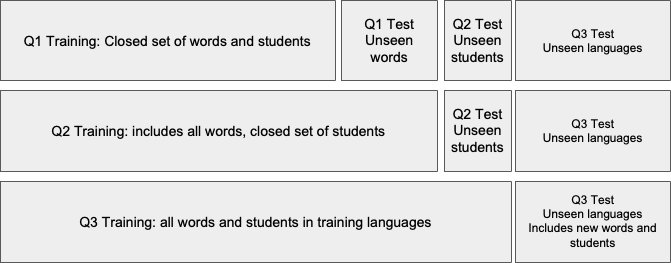